In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import json
from PIL import Image
import os
from torch.utils.data import random_split
import torch.nn as nn
import torch.optim as optim
import torchsummary
import torch.nn.init as init
import matplotlib.pyplot as plt

In [2]:
# Download data in json format

os.makedirs("images_train", exist_ok=True)
os.makedirs("images_test", exist_ok=True)


train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)


test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# Create JSON files for training and test datasets
def create_json(dataset, json_filename):
    data_list = []
    for i, (image, label) in enumerate(dataset):
        data_list.append({"img_path": f"{i}.png", "labels": label})
        base_name = os.path.basename(json_filename)
        type_data = base_name.split('_')[0] # returns train or test
        directory = "images_" + type_data
        image_path = os.path.join(directory, f"{i}.png")
        torchvision.utils.save_image(image, image_path)
    with open(json_filename, 'w') as json_file:
      for data in data_list:
        json.dump(data, json_file)
        json_file.write('\n')

create_json(train_data, "train_data.json")
create_json(test_data, "test_data.json")

100%|██████████| 26421880/26421880 [00:01<00:00, 16336144.28it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 329016.82it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5539067.67it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 1139434.14it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
# Dataset customed

class CustomImageDataset(Dataset):

    def __init__(self, json_filename, transform=None):
        """
        Arguments:
            json_filename (string): Json file with images paths and labels.
            transform (callable, optional): Optional transform to be applied.
        """
        self.data_list = []
        with open(json_filename, 'r') as file:
          for line in file:
              loaded_dict = json.loads(line)
              self.data_list.append(loaded_dict)
        self.transform = transform
        self.json_filename = json_filename

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
      img_path_aux = self.data_list[idx]['img_path']
      base_name = os.path.basename(self.json_filename)
      type_data = base_name.split('_')[0]
      directory = "images_" + type_data
      img_path = os.path.join(directory, img_path_aux)
      image = Image.open(img_path)
      if self.transform:
            image = self.transform(image)

      label = self.data_list[idx]['labels']
      return image, label


# Transforming the image in getitem
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    #transforms.RandomCrop((224,224))
    transforms.Grayscale(num_output_channels=1), # 28x28x1
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = CustomImageDataset("train_data.json", transform)
test_dataset = CustomImageDataset("test_data.json", transform)

In [4]:
# This code divides the training in train-val data

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

print("Train size: ", train_size, "\nValidation size: ", val_size, "\nTest size: ", len(test_dataset))
new_train_dataset, new_val_dataset = random_split(train_dataset, [train_size, val_size])

batch_size = 32
train_loader = DataLoader(new_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(new_val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Train size:  48000 
Validation size:  12000 
Test size:  10000


In [5]:
# BASELINE: LeNet-5 architecture
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(
            # convolution: 6 out channels/filters = 6@28x28, a convolution of 5x5 is applied -> kernel_size 5
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),   # padding 2 because input images are 28x28 (not 32x32)
            nn.ReLU(),
            # average pooling
            nn.AvgPool2d(kernel_size=2, stride=2),  # 14*14
            # convolution: it recieves 6 from previous convolution and now 16@10x10
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),

        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10),
        )

    def forward(self, x):
      return self.classifier(self.feature(x))


# Kaiming Uniform initialization
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            init.constant_(m.bias, 0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

baseline_model = LeNet5().to(device)

torchsummary.summary(baseline_model, input_size=(1,28 , 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              ReLU-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
           Flatten-7                  [-1, 400]               0
            Linear-8                  [-1, 120]          48,120
              ReLU-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
             ReLU-11                   [-1, 84]               0
           Linear-12                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
---------------------------------

In [6]:
# Model 1: Adding Dropout
class LeNet5_Dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=84, out_features=10),
        )

    def forward(self, x):
        return self.classifier(self.feature(x))


# Model 2: Adding Batch Normalization
class LeNet5_BatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10),
        )

    def forward(self, x):
        return self.classifier(self.feature(x))


# Model 3: Changing Activation Function to Leaky ReLU
class LeNet5_LeakyReLU(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),
            nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.LeakyReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.LeakyReLU(),
            nn.Linear(in_features=84, out_features=10),
        )

    def forward(self, x):
        return self.classifier(self.feature(x))


# Model 4: Changing Kernel Size
class LeNet5_KernelSize(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=7, stride=1, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=256, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10),
        )

    def forward(self, x):
        return self.classifier(self.feature(x))

# Model 0: Changing Kernel Size
class LeNet5_LessKernelSize(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=4, stride=1, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=400, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10),
        )

    def forward(self, x):
        return self.classifier(self.feature(x))


# Model 5: Increasing Number of Filters
class LeNet5_NumFilters(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5, stride=1, padding=2),  # Increased number of filters
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=12, out_channels=32, kernel_size=5, stride=1),  # Increased number of filters
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=32*5*5, out_features=120),  # Adjusted output size
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10),
        )

    def forward(self, x):
        return self.classifier(self.feature(x))



In [7]:
def train(model, device, train_loader, optimizer, criterion, epochs = 5):
  training_loss = 0.0

  model.train()
  correct, total = 0, 0
  for batch_idx, (images, labels) in enumerate(train_loader):
      images, labels = images.to(device), labels.to(device)

      # Forward Pass
      output = model(images)
      loss = criterion(output, labels)

      # Backward Pass
      loss.backward()
      optimizer.step() # updates model parameters using gradient computings by back propagation and applies the optimization algo
      optimizer.zero_grad()


      _, predicted = output.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()

      training_loss += loss.item()
      if batch_idx % 100 == 99:
          print(f'Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item()}')

  training_accuracy = 100 * correct / total
  average_training_loss = training_loss / len(train_loader)
  print(f"Train accuracy: {training_accuracy} %, Average Loss: {average_training_loss}")
  return training_accuracy, average_training_loss


def test(data_loader, model, loss_fn, type_test):
  with torch.no_grad():
      correct, total , loss = 0, 0, 0
      num_batches = len(data_loader)
      model.eval()
      for images, labels in data_loader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          loss += loss_fn(outputs, labels.long() ).item()

          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  loss /= num_batches
  accuracy = 100*correct/total
  print(f"{type_test} accuracy: {accuracy} %, Average Loss: {loss}")
  return accuracy, loss

In [8]:
def run (models, optimizers, criterions, epochs = 15):
  models_results = []
  for model, optimizer, criterion in zip(models, optimizers, criterions):
    training_losses = []
    validation_losses = []
    training_accuracies = []
    validation_accuracies = []
    print("Model: ", type(model).__name__)
    for t in range(epochs):
      print(f"Epoch {t+1}\n---------------------")
      training_accuracy, training_loss = train(model, device, train_loader, optimizer, criterion)
      validation_accuracy, validation_loss = test(val_loader, model, criterion, "Validation")
      training_losses.append(training_loss)
      training_accuracies.append(training_accuracy)
      validation_accuracies.append(validation_accuracy)
      validation_losses.append(validation_loss)
    models_results.append([training_losses, training_accuracies, validation_losses, validation_accuracies])
  return models_results

In [9]:
LeNet5_Dropout = LeNet5_Dropout().to(device)
LeNet5_BatchNorm = LeNet5_BatchNorm().to(device)
LeNet5_LeakyReLU = LeNet5_LeakyReLU().to(device)
LeNet5_KernelSize = LeNet5_KernelSize().to(device)
LeNet5_LessKernelSize = LeNet5_LessKernelSize().to(device)
LeNet5_NumFilters = LeNet5_NumFilters().to(device)
learning_rate = LeNet5().to(device)

In [10]:
torchsummary.summary(LeNet5_Dropout, input_size=(1,28 , 28))
torchsummary.summary(LeNet5_BatchNorm, input_size=(1,28 , 28))
torchsummary.summary(LeNet5_LeakyReLU, input_size=(1,28 , 28))
torchsummary.summary(LeNet5_KernelSize, input_size=(1,28 , 28))
torchsummary.summary(LeNet5_LessKernelSize, input_size=(1,28 , 28))
torchsummary.summary(LeNet5_NumFilters, input_size=(1,28 , 28))
torchsummary.summary(learning_rate, input_size=(1,28 , 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              ReLU-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
           Flatten-7                  [-1, 400]               0
            Linear-8                  [-1, 120]          48,120
              ReLU-9                  [-1, 120]               0
          Dropout-10                  [-1, 120]               0
           Linear-11                   [-1, 84]          10,164
             ReLU-12                   [-1, 84]               0
          Dropout-13                   [-1, 84]               0
           Linear-14                   

In [11]:
baseline_model.apply(init_weights)
LeNet5_Dropout.apply(init_weights)
LeNet5_BatchNorm.apply(init_weights)
LeNet5_LeakyReLU.apply(init_weights)
LeNet5_KernelSize.apply(init_weights)
LeNet5_NumFilters.apply(init_weights)
LeNet5_LessKernelSize.apply(init_weights)
learning_rate.apply(init_weights)



optimizer_baseline = optim.Adam(baseline_model.parameters(), lr=0.001)
optimizer_dropout = optim.Adam(LeNet5_Dropout.parameters(), lr=0.001)
optimizer_batchnorm = optim.Adam(LeNet5_BatchNorm.parameters(), lr=0.001)
optimizer_leakyrelu = optim.Adam(LeNet5_LeakyReLU.parameters(), lr=0.001)
optimizer_kernelsize = optim.Adam(LeNet5_KernelSize.parameters(), lr=0.001)
optmiizer_lesskernelsize = optim.Adam(LeNet5_LessKernelSize.parameters(), lr=0.001)
optimizer_numfilters = optim.Adam(LeNet5_NumFilters.parameters(), lr=0.001)
optimizer_learningrate = optim.Adam(learning_rate.parameters(), lr=0.005)


criterion_baseline = nn.CrossEntropyLoss()
criterion_dropout = nn.CrossEntropyLoss()
criterion_batchnorm = nn.CrossEntropyLoss()
criterion_leakyrelu = nn.CrossEntropyLoss()
criterion_kernelsize = nn.CrossEntropyLoss()
criterion_numfilters = nn.CrossEntropyLoss()
criterion_lesskernelsize = nn.CrossEntropyLoss()
criterion_learningrate = nn.CrossEntropyLoss()


In [12]:
models = [LeNet5_NumFilters, LeNet5_KernelSize, LeNet5_LessKernelSize, baseline_model, LeNet5_Dropout, LeNet5_BatchNorm, LeNet5_LeakyReLU,learning_rate ]
optimizers = [optimizer_numfilters, optimizer_kernelsize,optmiizer_lesskernelsize, optimizer_baseline, optimizer_dropout, optimizer_batchnorm, optimizer_leakyrelu,optimizer_learningrate ]
criterions = [criterion_numfilters, criterion_kernelsize, criterion_lesskernelsize ,criterion_baseline, criterion_dropout, criterion_batchnorm, criterion_leakyrelu, criterion_learningrate ]

models_results = run(models, optimizers, criterions)

Model:  LeNet5_NumFilters
Epoch 1
---------------------
Batch 100/1500, Loss: 0.6680095791816711
Batch 200/1500, Loss: 0.41511231660842896
Batch 300/1500, Loss: 1.052117109298706
Batch 400/1500, Loss: 0.8007088303565979
Batch 500/1500, Loss: 0.2621173560619354
Batch 600/1500, Loss: 0.4546789228916168
Batch 700/1500, Loss: 0.5573933720588684
Batch 800/1500, Loss: 0.40474727749824524
Batch 900/1500, Loss: 0.22769173979759216
Batch 1000/1500, Loss: 0.3266976475715637
Batch 1100/1500, Loss: 0.3298550546169281
Batch 1200/1500, Loss: 0.3290592133998871
Batch 1300/1500, Loss: 0.34552305936813354
Batch 1400/1500, Loss: 0.30857664346694946
Batch 1500/1500, Loss: 0.22686755657196045
Train accuracy: 82.11666666666666 %, Average Loss: 0.48704049408435823
Validation accuracy: 87.13333333333334 %, Average Loss: 0.3497054519454638
Epoch 2
---------------------
Batch 100/1500, Loss: 0.4097130298614502
Batch 200/1500, Loss: 0.2621680200099945
Batch 300/1500, Loss: 0.2939831614494324
Batch 400/1500, Los

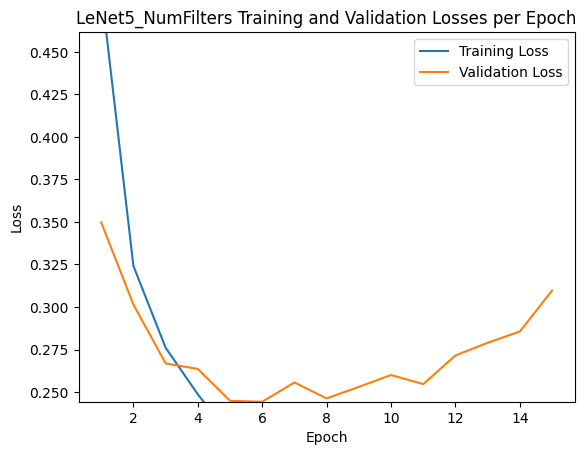

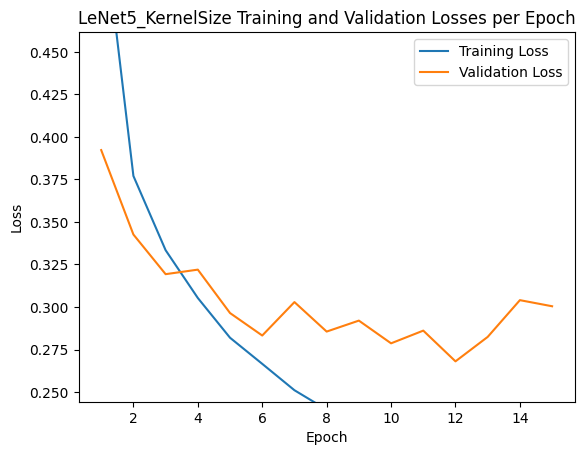

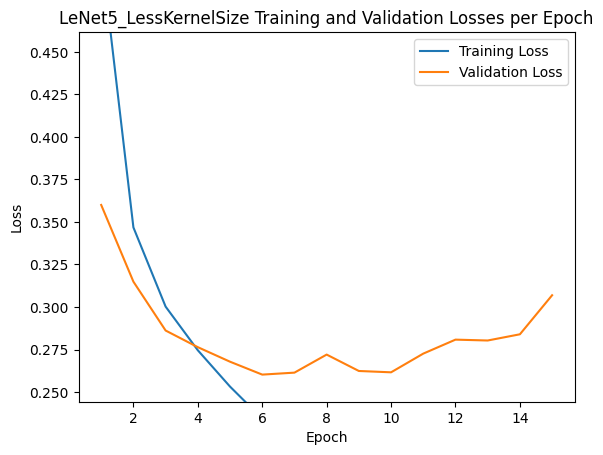

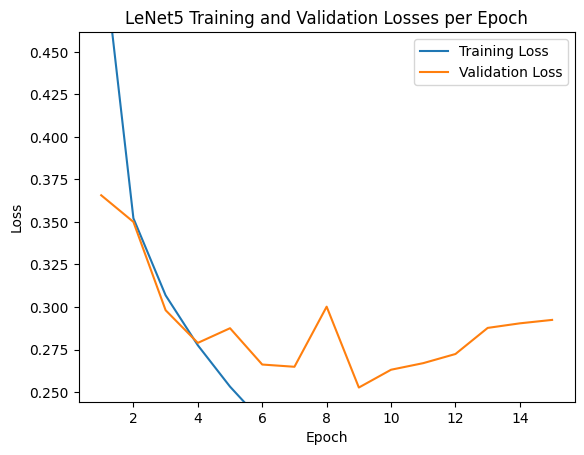

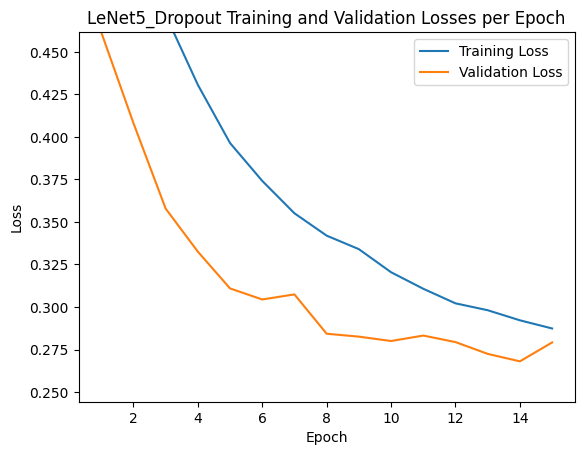

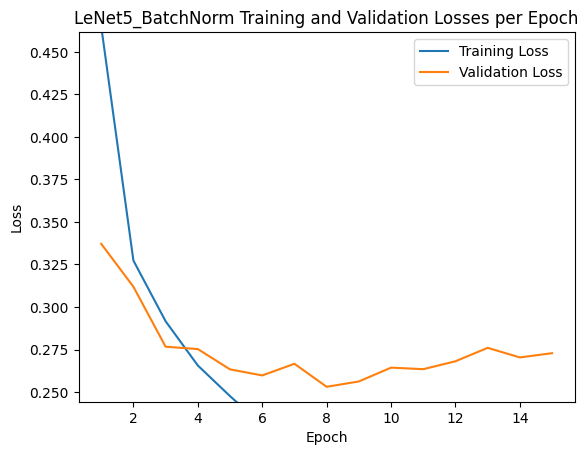

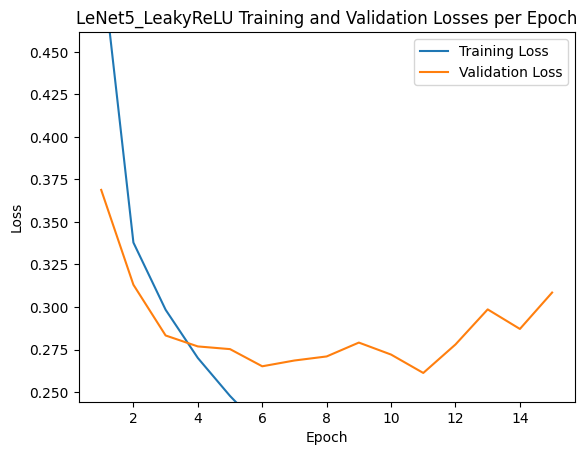

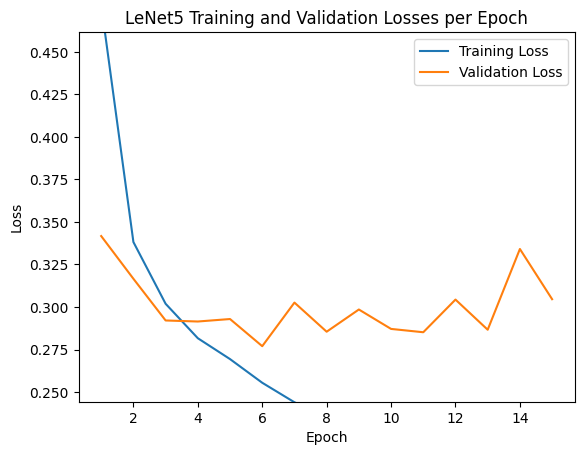

In [13]:
def plot_losses(models_results):
    min_loss = float('inf')
    max_loss = float('-inf')

    for i, result in enumerate(models_results):
        _, _, validation_losses, _ = result
        min_loss = min(min_loss, min(validation_losses))
        max_loss = max(max_loss, max(validation_losses))

    for i, result in enumerate(models_results):
        model_name = type(models[i]).__name__
        training_losses, _, validation_losses, _ = result

        plt.figure()

        plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Loss')
        plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')

        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'{model_name} Training and Validation Losses per Epoch')
        plt.legend()
        plt.ylim(min_loss, max_loss)
        plt.show()

plot_losses(models_results)



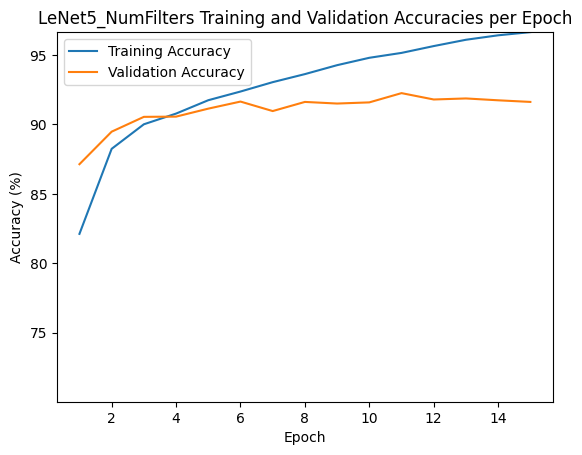

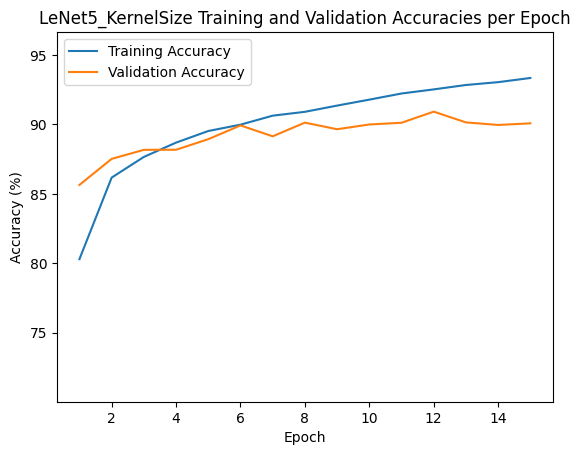

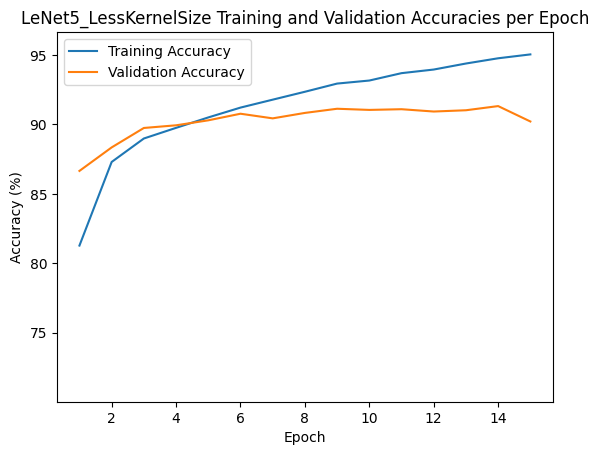

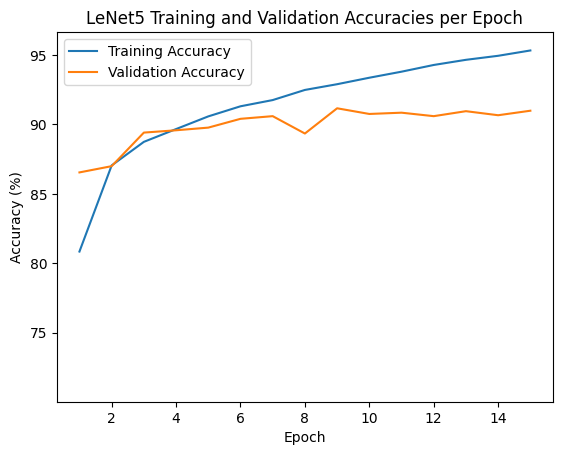

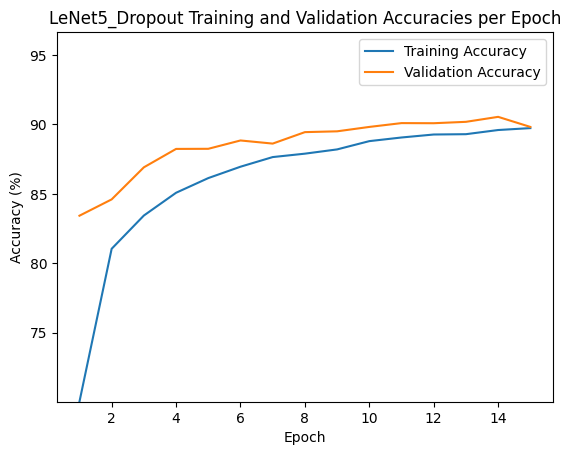

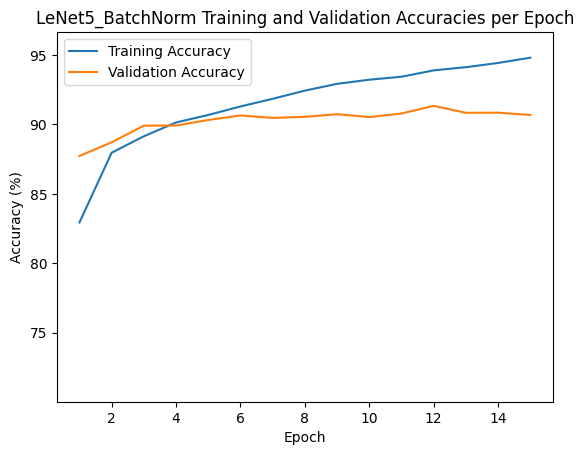

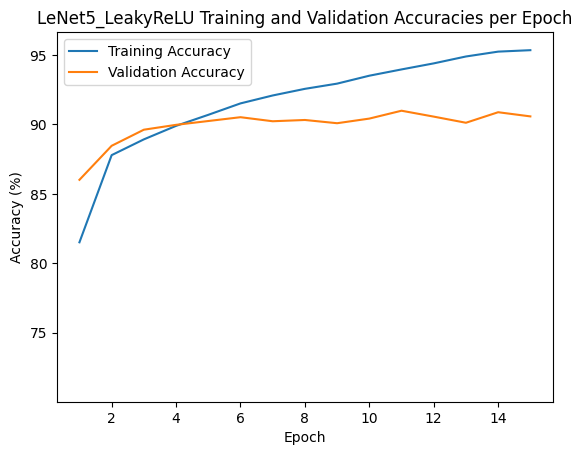

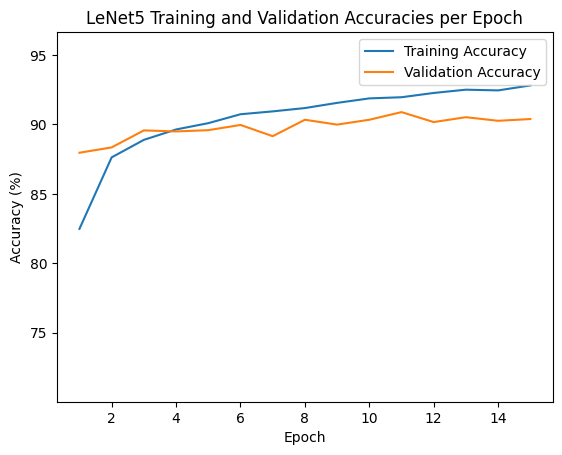

In [14]:
def plot_accuracies(models_results):
    min_accuracy = float('inf')
    max_accuracy = float('-inf')

    for i, result in enumerate(models_results):
        _, training_accuracies, _, validation_accuracies = result
        min_accuracy = min(min_accuracy, min(training_accuracies), min(validation_accuracies))
        max_accuracy = max(max_accuracy, max(training_accuracies), max(validation_accuracies))

    for i, result in enumerate(models_results):
        model_name = type(models[i]).__name__
        training_accuracies, validation_accuracies = result[1], result[3]

        plt.figure()

        plt.plot(range(1, len(training_accuracies) + 1), training_accuracies, label='Training Accuracy')
        plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label='Validation Accuracy')

        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title(f'{model_name} Training and Validation Accuracies per Epoch')
        plt.legend()
        plt.ylim(min_accuracy, max_accuracy)  # Set the y-axis limits for consistency
        plt.show()

plot_accuracies(models_results)

In [15]:
def get_best_models(model_results):
  lowest_validation_losses = []
  number_epochs = []

  for i, model_result in enumerate(models_results):
      validation_losses = model_result[2]
      lowest_validation_loss = min(validation_losses)
      lowest_validation_losses.append((i, lowest_validation_loss))  # Append as tuple

      epoch_index = validation_losses.index(lowest_validation_loss)
      number_epochs.append((i, epoch_index))

  lowest_validation_losses.sort(key=lambda x: x[1])

  print(lowest_validation_losses)

get_best_models(models_results)

[(0, 0.24430400499204794), (3, 0.2526457123806079), (5, 0.2530841496785482), (2, 0.2602479495505492), (6, 0.2612169423401356), (4, 0.26803329679369925), (1, 0.2680393959283829), (7, 0.2769589307208856)]


In [16]:
def final_test(dataloader_train, dataloader_test, final_model, final_optimizer, final_criterion, epochs=15):
  training_losses = []
  training_accuracies = []
  for t in range(epochs):
      print(f"Epoch {t+1}\n---------------------")
      training_accuracy, training_loss = train(final_model, device, train_loader, final_optimizer, final_criterion)
      training_losses.append(training_loss)
      training_accuracies.append(training_accuracy)
  accuracy_test, loss_test = test(dataloader_test, final_model, final_criterion, "Test")
  return accuracy_test, loss_test

# Train and Test Best Model:
final_model = LeNet5_NumFilters
final_model.apply(init_weights)
final_optimizer = optim.Adam(final_model.parameters(), lr=0.001)
final_criterion = criterion_numfilters

accuracy_test_train, loss_test_train = final_test(train_loader, test_loader, final_model, final_optimizer, final_criterion)

final_model.apply(init_weights)
final_optimizer = optim.Adam(final_model.parameters(), lr=0.001)
final_criterion = criterion_numfilters


train_val_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # train + val dataset
accuracy_test_trainval, loss_test_trainval = final_test(train_val_loader, test_loader, final_model, final_optimizer, final_criterion)

Epoch 1
---------------------
Batch 100/1500, Loss: 0.5073435306549072
Batch 200/1500, Loss: 0.36921077966690063
Batch 300/1500, Loss: 0.27901533246040344
Batch 400/1500, Loss: 0.6258859038352966
Batch 500/1500, Loss: 0.5038614273071289
Batch 600/1500, Loss: 0.21565234661102295
Batch 700/1500, Loss: 0.18810772895812988
Batch 800/1500, Loss: 0.25529396533966064
Batch 900/1500, Loss: 0.4315376579761505
Batch 1000/1500, Loss: 0.7203317880630493
Batch 1100/1500, Loss: 0.16317149996757507
Batch 1200/1500, Loss: 0.38765251636505127
Batch 1300/1500, Loss: 0.5341553092002869
Batch 1400/1500, Loss: 0.5088815093040466
Batch 1500/1500, Loss: 0.6580743193626404
Train accuracy: 83.03125 %, Average Loss: 0.46544431616862614
Epoch 2
---------------------
Batch 100/1500, Loss: 0.43407732248306274
Batch 200/1500, Loss: 0.2777007222175598
Batch 300/1500, Loss: 0.7559910416603088
Batch 400/1500, Loss: 0.3983922302722931
Batch 500/1500, Loss: 0.5516838431358337
Batch 600/1500, Loss: 0.4606230854988098
Bat